## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import RobertaTokenizer
import transformers

from text_data import TextDataset5 as TextDataset
from roberta import CustomRoberta
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
train = pd.read_csv(f'{path}train.csv')

In [3]:
%%time
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
cls = ' ' + tokenizer.cls_token
sep = ' ' + tokenizer.sep_token
q_target_tokens = [f'[Q{i}]' for i in range(N_Q_TARGETS)]
a_target_tokens = [f'[A{i}]' for i in range(N_A_TARGETS)]
tokenizer.add_tokens(q_target_tokens + a_target_tokens)

seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols, target_tokens in [('question', ['question_title', 'question_body'], q_target_tokens), 
                                      ('answer', ['question_title', 'answer'], a_target_tokens)]:
        pre_fix = ' '.join(target_tokens)
        ids, seg_ids, sent_ids = [], [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                pre_fix + cls + x1 + sep, x2 + sep, add_special_tokens=False, max_length=max_seq_len, 
                pad_to_max_length=True, return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



CPU times: user 15.1 s, sys: 95.5 ms, total: 15.2 s
Wall time: 16 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 2
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_roberta_test'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 3

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.roberta, lr / 100, weight_decay)
    )

Fold 1 started at Sun Feb  9 20:12:41 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


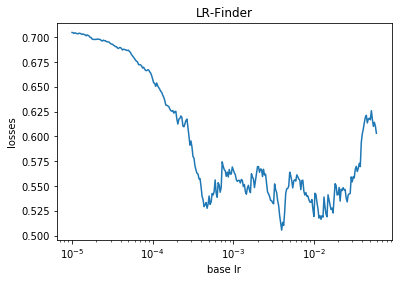

epoch 0: 	 Start training...



epoch 0/2 	 train : loss 0.51475 - spearmanr 0.22081
epoch 0: 	 Start validation...



epoch 0/2 	 valid : loss 0.47303 - spearmanr 0.36963
best model: epoch 0 - 0.36963
epoch 1: 	 Start training...



epoch 1/2 	 train : loss 0.45424 - spearmanr 0.39484
epoch 1: 	 Start validation...



epoch 1/2 	 valid : loss 0.45777 - spearmanr 0.40418
best model: epoch 1 - 0.40418
TRAINING END: Best score achieved on epoch 1 - 0.40418
Starting inference for model: checkpoints/siamese_roberta_test_fold_1_best.pth



Averaged Val. score: 0.4041797820264849
Starting inference for model: checkpoints/siamese_roberta_test_fold_1_best.pth



Fold 2 started at Sun Feb  9 20:31:59 2020
epoch 0: 	 Start training...



epoch 0/2 	 train : loss 0.51398 - spearmanr 0.22738
epoch 0: 	 Start validation...



epoch 0/2 	 valid : loss 0.46984 - spearmanr 0.3755
best model: epoch 0 - 0.3755
epoch 1: 	 Start training...



epoch 1/2 	 train : loss 0.45493 - spearmanr 0.39944
epoch 1: 	 Start validation...



epoch 1/2 	 valid : loss 0.45378 - spearmanr 0.40575
best model: epoch 1 - 0.40575
TRAINING END: Best score achieved on epoch 1 - 0.40575
Starting inference for model: checkpoints/siamese_roberta_test_fold_2_best.pth



Averaged Val. score: 0.4057495350026312
Starting inference for model: checkpoints/siamese_roberta_test_fold_2_best.pth



Fold 3 started at Sun Feb  9 20:49:48 2020
epoch 0: 	 Start training...



epoch 0/2 	 train : loss 0.51568 - spearmanr 0.22777
epoch 0: 	 Start validation...



epoch 0/2 	 valid : loss 0.46824 - spearmanr 0.36768
best model: epoch 0 - 0.36768
epoch 1: 	 Start training...



epoch 1/2 	 train : loss 0.45555 - spearmanr 0.40103
epoch 1: 	 Start validation...



epoch 1/2 	 valid : loss 0.45183 - spearmanr 0.4011
best model: epoch 1 - 0.4011
TRAINING END: Best score achieved on epoch 1 - 0.40110
Starting inference for model: checkpoints/siamese_roberta_test_fold_3_best.pth



Averaged Val. score: 0.4010953049974863
Starting inference for model: checkpoints/siamese_roberta_test_fold_3_best.pth



OOF score: 0.4021693955300795


In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomRoberta(256, cat_features_train.shape[1])
    model.roberta.resize_token_embeddings(len(tokenizer))
    
    if fold_id == 0:
#         print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
        
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [12]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 4 0.4695237289870974
4 8 0.3558644640873608
5 2 0.45699756728255236
9 64 0.09193072926867853
11 8 0.7295749249586639
12 4 0.5307253165577714
13 32 0.21620512691232463
14 4 0.6356314753939424
15 4 0.547143679857105
19 32 0.15026857350842404


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [13]:
np.array(opt_ds), np.array(opt_indices)

(array([ 4,  8,  2, 64,  8,  4, 32,  4,  4, 32]),
 array([ 2,  4,  5,  9, 11, 12, 13, 14, 15, 19]))

In [14]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [15]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.402169
CV unique rows,0.369588
CV ignoring hard targets,0.426253
CV unique rows ignoring hard targets,0.390721
CV w rounding,0.429059
CV unique rows w rounding,0.406353
CV ignoring hard targets w rounding,0.451056
CV unique rows ignoring hard targets w rounding,0.420441


In [16]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.406718
CV unique rows,0.374236
CV ignoring hard targets,0.426253
CV unique rows ignoring hard targets,0.390721
CV w rounding,0.430130
CV unique rows w rounding,0.407071
CV ignoring hard targets w rounding,0.451056
CV unique rows ignoring hard targets w rounding,0.420441


In [17]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [18]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.803121,0.578879,0.489661,0.399938,0.409098,0.319415,0.664265,0.720194,0.674373,0.003707,0.803175,0.771694,0.051515,0.161038,0.012600,0.022557,0.081167,0.174229,0.743575,0.001648,0.821103,0.634064,0.307517,0.767966,0.769863,0.429629,0.049696,0.070265,0.757271,0.701354
1,46,0.495713,0.277796,0.010198,0.646514,0.659808,0.860129,0.395288,0.251435,0.143731,0.022133,0.504304,0.188044,0.004795,0.003641,0.002106,0.018333,0.844462,0.346800,0.268687,0.000593,0.343295,0.747742,0.473797,0.807941,0.871594,0.543640,0.880046,0.310966,0.191656,0.580610
2,70,0.754226,0.642908,0.100584,0.685799,0.790123,0.806003,0.592695,0.532348,0.349825,0.006646,0.335617,0.730656,0.064009,0.115131,0.014124,0.048073,0.138290,0.143779,0.652720,0.003761,0.749688,0.645934,0.301057,0.765259,0.720999,0.464788,0.070067,0.077995,0.719978,0.611803
3,132,0.558816,0.217205,0.008361,0.608067,0.675292,0.851019,0.412323,0.256816,0.172427,0.023298,0.519185,0.091883,0.003403,0.004690,0.001285,0.012266,0.793397,0.303936,0.621551,0.000363,0.386260,0.790267,0.590454,0.876938,0.914798,0.638668,0.823543,0.309252,0.624877,0.608618
4,200,0.743336,0.417291,0.105999,0.713339,0.738357,0.760239,0.585286,0.571216,0.429551,0.017083,0.436373,0.689848,0.060955,0.075442,0.016638,0.099316,0.272856,0.245687,0.591264,0.007469,0.581595,0.733336,0.527137,0.834218,0.818127,0.591296,0.428474,0.279284,0.663951,0.610491


In [19]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [20]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.775944,0.559314,0.361918,0.537536,0.501071,0.309323,0.595532,0.540656,0.340244,0.015247,0.793570,0.407521,0.391436,0.085087,0.027885,0.160238,0.187498,0.125049,0.593292,0.004279,0.725390,0.763058,0.502010,0.902161,0.831526,0.588231,0.142031,0.123412,0.809501,0.702639
1,0.901174,0.775461,0.112159,0.593328,0.901401,0.524309,0.597503,0.737481,0.393935,0.008381,0.260907,0.079190,0.651250,0.005363,0.805488,0.111560,0.047190,0.084828,0.260725,0.023502,0.842692,0.674150,0.388994,0.818397,0.769484,0.440604,0.022337,0.042238,0.391146,0.803872
2,0.677441,0.400371,0.021028,0.694911,0.821308,0.826873,0.500877,0.331381,0.326437,0.006420,0.327795,0.225577,0.030330,0.008452,0.008925,0.206840,0.619953,0.316535,0.305310,0.001806,0.592188,0.855954,0.585329,0.923645,0.893427,0.675591,0.705572,0.350998,0.479636,0.707117
3,0.829315,0.695406,0.148865,0.761560,0.819372,0.786958,0.632025,0.670560,0.287968,0.001311,0.285380,0.903617,0.010372,0.016965,0.050903,0.101102,0.036672,0.091600,0.422112,0.002760,0.833947,0.667121,0.624446,0.767774,0.676417,0.583941,0.035749,0.071292,0.713080,0.642325
4,0.800288,0.803855,0.007004,0.695890,0.835457,0.916796,0.494963,0.450717,0.291991,0.000786,0.290514,0.618988,0.003331,0.001678,0.001427,0.039735,0.830968,0.304281,0.111800,0.000143,0.855497,0.642116,0.317764,0.758581,0.774360,0.424860,0.812824,0.300467,0.060818,0.585198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.766669,0.547068,0.144951,0.669440,0.743098,0.596214,0.625792,0.547995,0.526492,0.003839,0.453484,0.882708,0.151005,0.077500,0.025948,0.169113,0.108982,0.138009,0.385843,0.003470,0.750193,0.853134,0.710010,0.897239,0.886803,0.675499,0.119235,0.112337,0.763302,0.772733
6075,0.749507,0.419552,0.160871,0.595531,0.522130,0.381654,0.668551,0.622338,0.187735,0.013911,0.752650,0.097165,0.051928,0.020150,0.005580,0.099173,0.695188,0.440227,0.221663,0.001968,0.665586,0.755776,0.616009,0.866352,0.878208,0.633515,0.697244,0.407471,0.467326,0.771181
6076,0.592820,0.366592,0.015716,0.665540,0.681991,0.850067,0.412520,0.316447,0.277966,0.011855,0.466357,0.569810,0.009827,0.008029,0.003234,0.014207,0.812681,0.376819,0.190531,0.001441,0.499564,0.606409,0.412201,0.765793,0.780655,0.453707,0.660160,0.261742,0.473818,0.502992
6077,0.808328,0.622121,0.618136,0.457222,0.279861,0.228573,0.618312,0.706360,0.502276,0.008809,0.869757,0.815475,0.224128,0.134567,0.056970,0.026670,0.033832,0.092125,0.687977,0.003820,0.787363,0.812193,0.658241,0.839368,0.854630,0.652124,0.031851,0.102977,0.861151,0.790549


In [21]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.381294
question_body_critical                   0.584536
question_conversational                  0.408369
question_expect_short_answer             0.298952
question_fact_seeking                    0.351951
question_has_commonly_accepted_answer    0.424967
question_interestingness_others          0.360027
question_interestingness_self            0.501207
question_multi_intent                    0.514576
question_not_really_a_question           0.084058
question_opinion_seeking                 0.468895
question_type_choice                     0.721321
question_type_compare                    0.359985
question_type_consequence                0.183746
question_type_definition                 0.364766
question_type_entity                     0.432073
question_type_instructions               0.777632
question_type_procedure                  0.358746
question_type_reason_explanation         0.669104
question_type_spelling                   0.045935


In [22]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.045935,3.0
question_not_really_a_question,0.084058,5.0
answer_plausible,0.144270,9.0
answer_relevance,0.177273,9.0
question_type_consequence,0.183746,5.0
answer_well_written,0.199110,9.0
answer_helpful,0.235770,9.0
question_expect_short_answer,0.298952,5.0
answer_type_procedure,0.311338,5.0
answer_satisfaction,0.334822,17.0


In [23]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

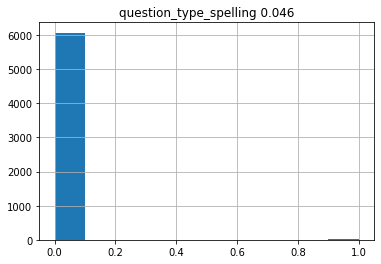

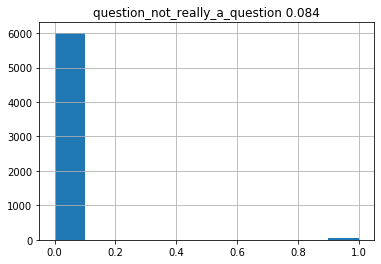

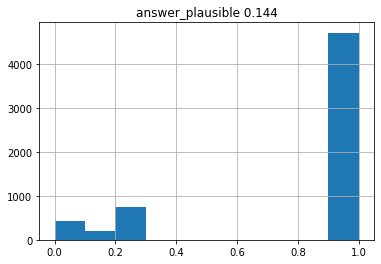

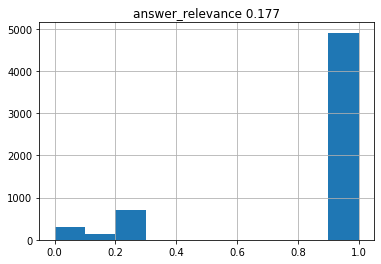

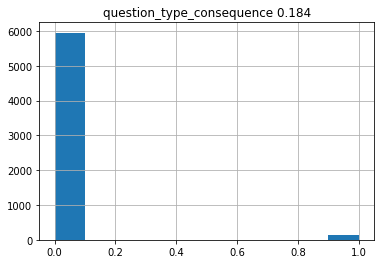

In [24]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


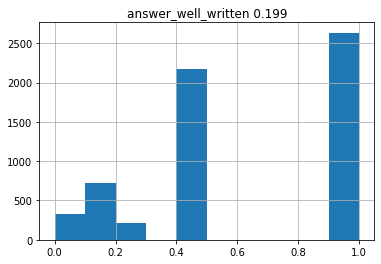

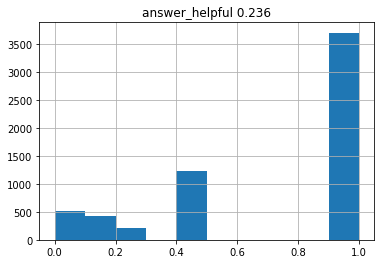

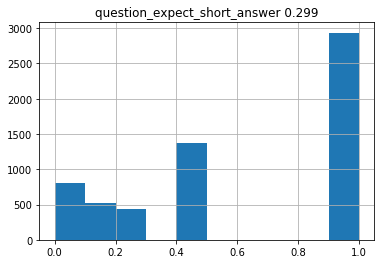

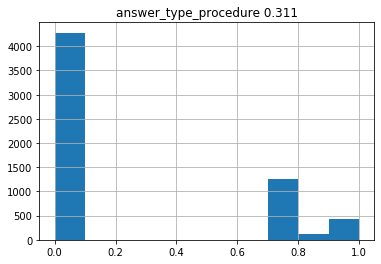

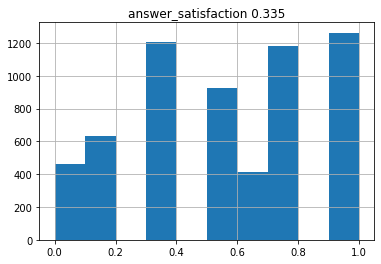

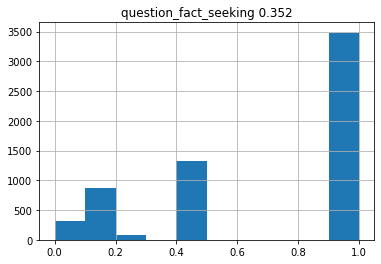

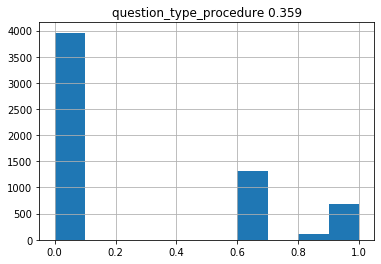

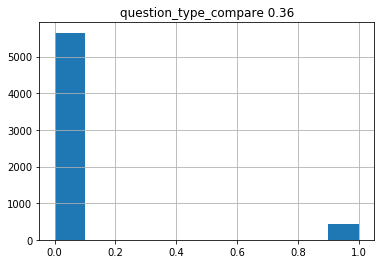

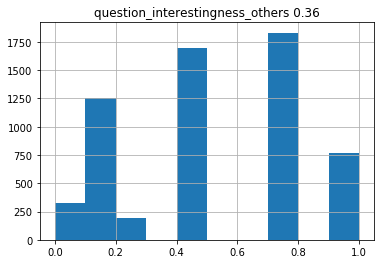

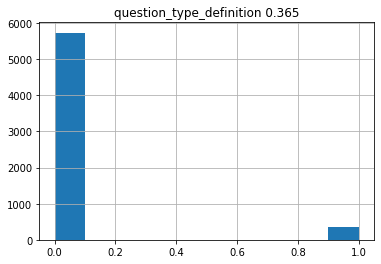

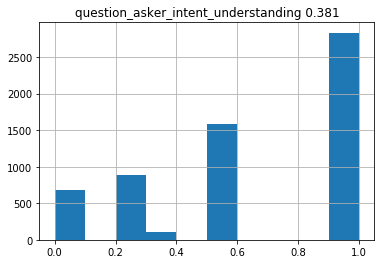

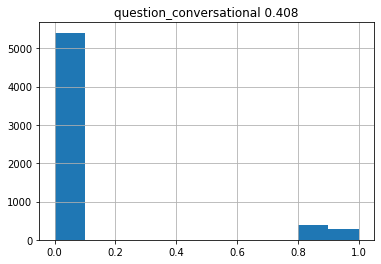

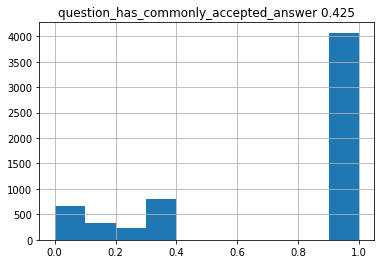

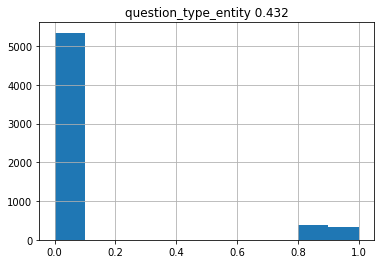

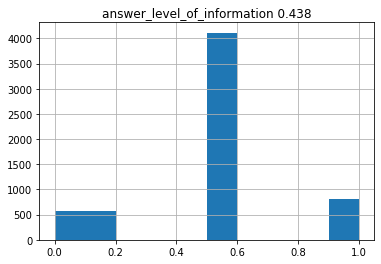

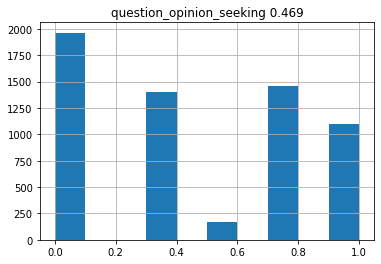

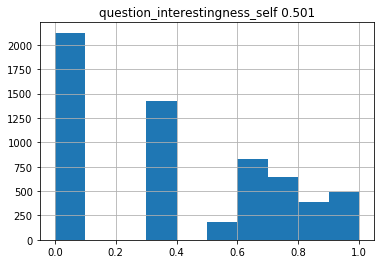

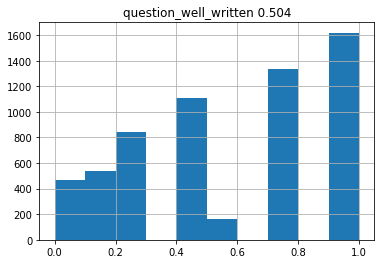

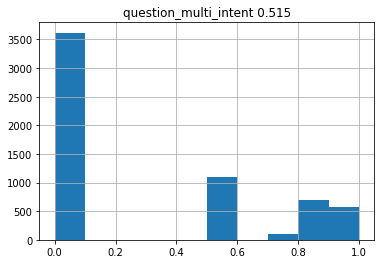

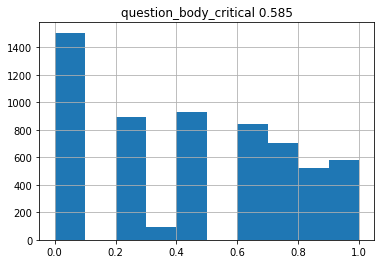

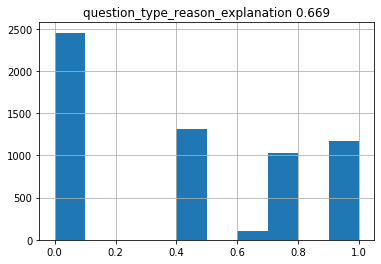

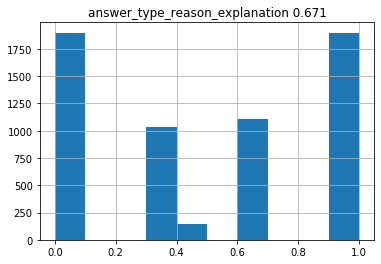

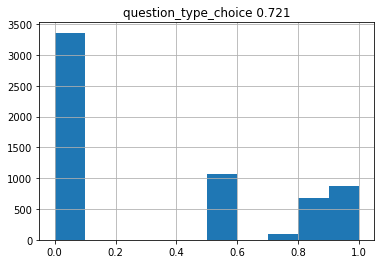

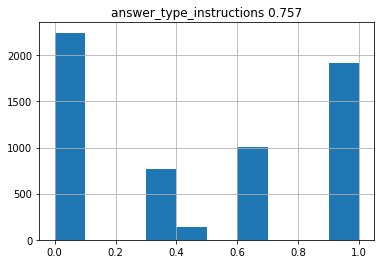

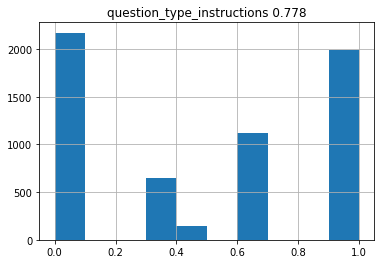

In [25]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')